In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
#python -m spacy download en_core_web_sm
#python -m spacy download en_core_web_md
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
from sklearn.datasets import fetch_20newsgroups

import pickle
import bz2
import time
import logging
import os



C:\Users\jorda\anaconda3\envs\WH\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jorda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Bug fix for pyLDAvis https://github.com/bmabey/pyLDAvis/issues/162
from IPython.display import HTML
css_str = '<style> \
.jp-Button path { fill: #616161;} \
text.terms { fill: #616161;} \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str ))

# Load datapickle 
From wikidownloader.py

In [3]:
print('Load data pickle')
with bz2.BZ2File('datapicklesoup.bz2', 'rb') as f:  #Use datacompression BZ2
    data= pickle.load(f)
print('Loaded data pickle')
    
df=pd.DataFrame({'text':data[0],'title':data[1]})

Load data pickle
Loaded data pickle


In [4]:
df

,text,title
0,Megacraspedus cuencellus is a moth of the fami...,Megacraspedus_cuencellus
1,Jellyfish dermatitis is a cutaneous condition ...,Jellyfish_dermatitis
2,The Hadrianic Society was a British historical...,Hadrianic_Society
3,The CPL–U Sports Draft (French: Repêchage de l...,CPL%E2%80%93U_Sports_Draft
4,Mikhail Ivanovich Meltyukhov (Russian: Russian...,Mikhail_Meltyukhov
...,...,...
49884,Swertia perennis is a species of flowering pla...,Swertia_perennis
49885,Sarah Johns (born 1979) is an American country...,Sarah_Johns
49886,Abū Thābit Sulaymān ibn Saʿd al-Khūshani (Arab...,Sulayman_ibn_Sa%27d_al-Khushani
49887,Argyresthia pilatella is a moth of the family ...,Argyresthia_pilatella


In [5]:
#remove zero length articles
articlelen=df.text.apply(len)
df=df[articlelen>10]

# Tokenizing articles


In [6]:
def sent_to_words(sentences):
   for sentence in sentences:
      yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
data_words = list(sent_to_words(df.text))

In [7]:
print(df.text[0][:400])

Megacraspedus cuencellus is a moth of the family Gelechiidae. It was described by Aristide Caradja in 1920. It is found in France and Spain. The forewings are uniform mouse grey with the margin whitish from one-third to the apex. The hindwings are mouse grey. 


In [8]:
print(data_words[0][:40])

['megacraspedus', 'cuencellus', 'is', 'moth', 'of', 'the', 'family', 'gelechiidae', 'it', 'was', 'described', 'by', 'aristide', 'caradja', 'in', 'it', 'is', 'found', 'in', 'france', 'and', 'spain', 'the', 'forewings', 'are', 'uniform', 'mouse', 'grey', 'with', 'the', 'margin', 'whitish', 'from', 'one', 'third', 'to', 'the', 'apex', 'the', 'hindwings']


In [9]:
id2word = corpora.Dictionary(data_words)
texts = data_words
corpus = [id2word.doc2bow(text) for text in texts]
print([(id2word[id], freq) for id, freq in corpus[0]][:20])
print(corpus[0][:20]) #it will print the corpus we created above.



[('and', 1), ('apex', 1), ('are', 2), ('aristide', 1), ('by', 1), ('caradja', 1), ('cuencellus', 1), ('described', 1), ('family', 1), ('forewings', 1), ('found', 1), ('france', 1), ('from', 1), ('gelechiidae', 1), ('grey', 2), ('hindwings', 1), ('in', 2), ('is', 2), ('it', 2), ('margin', 1)]
[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 2), (17, 2), (18, 2), (19, 1)]


# Removing stop words and adding bigrams

In [10]:

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
def remove_stopwords(texts):
   return [[word for word in simple_preprocess(str(doc)) 
   if word not in stop_words] for doc in texts]
def make_bigrams(texts):
   return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
   return [trigram_mod[bigram_mod[doc]] for doc in texts]

data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)


In [11]:
print(data_words_nostops[0][:40])

['megacraspedus', 'cuencellus', 'moth', 'family', 'gelechiidae', 'described', 'aristide', 'caradja', 'found', 'france', 'spain', 'forewings', 'uniform', 'mouse', 'grey', 'margin', 'whitish', 'one', 'third', 'apex', 'hindwings', 'mouse', 'grey']


In [12]:
print(data_words_bigrams[0][:40])

['megacraspedus', 'cuencellus', 'moth', 'family_gelechiidae', 'described', 'aristide', 'caradja', 'found', 'france', 'spain', 'forewings', 'uniform', 'mouse', 'grey', 'margin', 'whitish', 'one', 'third', 'apex', 'hindwings', 'mouse', 'grey']


# Lemmatization

Reference: https://www.researchgate.net/publication/341574872_Machine_Learning_and_Deep_Neural_Network-Based_Lemmatization_and_Morphosyntactic_Tagging_for_Serbian


The basic set of PoS-categories/tags that should be as-signed to tokens is not generally accepted, even for a speciﬁc language. The choice of a tagset usually depends on the foreseen task or project. A tagset tailored to be applicable for PoS-tagging in general is the Universal Part-of-Speech (UPoS) tagset (Petrov et al., 2012) (used by spaCy), and it lists the following 17 categories: adjective(ADJ), adposition (ADP), adverb (ADV), auxiliary (AUX),coordinating conjunction (CCONJ), determiner (DET), interjection (INTJ), noun (N), numerical (NUM), particle(PART), pronoun (PRON), proper noun (PROPN), punctuation (PUNCT), subordinating conjunction (SCONJ), symbol (SYM), verb (VERB) and other (X). It should be notedthat the MULTEXT-East tagset (Erjavec, 2012) was alsotailored to be universal. SMD uses its own tagset thatcorresponds closely to Serbian traditional grammars. TheSerbian TreeTagger models TT11 and TT19 (see Subsec-tion 3.3.) use modiﬁcations of the SMD tagset. A gen-eral overview of the tagsets used is presented in Table 3.It should be noted that tags for some PoS differ betweentagsets (e.g. ADJ in UPoS vs. A in SMD for adjective

In [13]:
doc=nlp(" ".join(data_words_bigrams[0]))

In [14]:
tags=[]
for w in doc:
    if not w.pos_ in tags:
        print('Lemmatization Example {} -> {}'.format(w.lemma_,w.pos_))
        tags.append(w.pos_)
tags

Lemmatization Example megacraspedus -> PROPN
Lemmatization Example moth -> NOUN
Lemmatization Example describe -> VERB
Lemmatization Example whitish -> ADJ
Lemmatization Example one -> NUM


['PROPN', 'NOUN', 'VERB', 'ADJ', 'NUM']

We will only keep the UPoS with the following tags 'NOUN', 'ADJ', 'VERB', 'ADV'

In [15]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
   texts_out = []
   for sent in texts:
      doc = nlp(" ".join(sent))
      texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
   return texts_out

def lemmatization2(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
   texts_out = []
   for sent in texts:
      doc = nlp(sent)
      texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
   return texts_out


In [16]:
#bigrams, then lemmatize, then remove stop words
data_lemmatized = make_bigrams(data_words)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_lemmatized, allowed_postags=[
   'NOUN', 'ADJ', 'VERB', 'ADV'
])
data_lemmatized = remove_stopwords(data_lemmatized)


In [17]:
print(data_lemmatized[0][:40]) #it will print the lemmatized data.

['describe', 'find', 'forewing', 'uniform', 'mouse', 'grey', 'margin', 'whitish', 'third', 'apex', 'hindwing', 'mouse', 'grey']


In [18]:
print(data_words_bigrams[0][:55])

['megacraspedus', 'cuencellus', 'moth', 'family_gelechiidae', 'described', 'aristide', 'caradja', 'found', 'france', 'spain', 'forewings', 'uniform', 'mouse', 'grey', 'margin', 'whitish', 'one', 'third', 'apex', 'hindwings', 'mouse', 'grey']


# Creating bag of words frequencies

Without Lemmatization

In [19]:
id2word = corpora.Dictionary(data_words_bigrams)
texts = data_words_bigrams
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[0][:20]) #it will print the corpus we created above.
[(id2word[id], freq) for id, freq in corpus[0]][:20]
#it will print the words with their frequencies.


[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)]


[('apex', 1),
 ('aristide', 1),
 ('caradja', 1),
 ('cuencellus', 1),
 ('described', 1),
 ('family_gelechiidae', 1),
 ('forewings', 1),
 ('found', 1),
 ('france', 1),
 ('grey', 2),
 ('hindwings', 1),
 ('margin', 1),
 ('megacraspedus', 1),
 ('moth', 1),
 ('mouse', 2),
 ('one', 1),
 ('spain', 1),
 ('third', 1),
 ('uniform', 1),
 ('whitish', 1)]

In [20]:
print(f'Number of unique tokens: {len(id2word)}')
print(f'Number of documents: {len(corpus)}')

Number of unique tokens: 380536
Number of documents: 49835


With Lemmatization

In [21]:
id2word_lemmatized = corpora.Dictionary(data_lemmatized)

# Filter out words that occur less than X documents, 
# or more than X% of the documents.
id2word_lemmatized.filter_extremes(no_below=10, no_above=0.1)

corpus_lemmatized = [id2word_lemmatized.doc2bow(text) for text in data_lemmatized]
print(corpus_lemmatized[0][:20]) #it will print the corpus we created above.
[(id2word_lemmatized[id], freq) for id, freq in corpus_lemmatized[0]][:20]
#it will print the words with their frequencies.


[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1)]


[('apex', 1),
 ('describe', 1),
 ('forewing', 1),
 ('grey', 2),
 ('hindwing', 1),
 ('margin', 1),
 ('mouse', 2),
 ('third', 1),
 ('uniform', 1),
 ('whitish', 1)]

In [95]:
print(f'Number of unique tokens: {len(id2word_lemmatized)}')
print(f'Number of documents: {len(corpus_lemmatized)}')

Number of unique tokens: 26262
Number of documents: 49835


In [23]:
dictwords=set(id2word_lemmatized.values())

In [24]:
data_lemmatized_filtered=[[w for w in article if w in dictwords] for article in data_lemmatized]

# Fitting via LDA Variational Inference (Gensim) library

About Gensim algorithmn

The core estimation code is based on the `onlineldavb.py script

    https://github.com/blei-lab/onlineldavb/blob/master/onlineldavb.py
    Matthew D. Hoffman, David M. Blei, Francis Bach:
    
Online Learning for Latent Dirichlet Allocation', NIPS 2010

    Hoffman et al.: online-lda_
    https://papers.neurips.cc/paper/2010/file/71f6278d140af599e06ad9bf1ba03cb0-Paper.pdf


![LDA ALGO](https://github.com/duha-aldebakel/DSC180B-LDACode/blob/master/images/VB_LDA.PNG?raw=true)

![LDA ALGO](https://github.com/duha-aldebakel/DSC180B-LDACode/blob/master/images/VB_LDA_Algo1.PNG?raw=true)

EM Algorihmn explanation:

Given the statistical model which generates a set w  of observed data (corpus), a set of unobserved latent data beta and theta, and a vector of unknown parameters lambda, along with a likelihood function

    First, initialize the parameters lambda to some random values.
    E: Compute the probability of each possible value of beta and theta, given lambda λ
    M: Use the just-computed probability disribution of beta and theta to compute a better estimate for the parameters lambda
    Iterate E-step 2 and M-step 3 until convergence.

E step: 

    fits phi φ(per word topic assignment) and gamma γ (topic assignment for document k)
    note phi φ is the associated variational parameter of z

    for every document
      hillclimb until peak
        phi φ (per word topic assignment) 
        word w in document d is likely part of topic k if 
          theta, the topic distribution for that document d is high for k
          plus
          beta, the word w is often associated with topic k
        gamma γ (topic assignment for document k)
          has its distribution by taking into account 
          phi (per word topic assignment)  times n
          n is the frequency word w appears in document d. 
      
M step:

    fits lambda λ, the distribution of words across topics
    (lambda λ is the associated variational parameter to beta)



randomly guess words in topic (lamda)
E step:
do our best given lamba to
a) assign speciic words in specific documents to topics
b) then assign topics to documents based on step a frequency
M step:
survey E step a and b to assign words to topics in a better way


Set up logging

In [25]:

def setUpNewLogFile(LOG_FILENAME):

    #logging.basicConfig(filename=LOG_FILENAME,
    #                    format="%(asctime)s:%(levelname)s:%(message)s",
    #                    level=logging.INFO)

    my_logger = logging.getLogger()
    my_logger.setLevel(logging.INFO)
    my_logger.handlers.clear()
    handlers = my_logger.handlers[:]
    for handler in handlers:
        handler.close()
        my_logger.removeHandler(handler)

    # Check if log exists and should therefore be rolled
    needRoll = os.path.isfile(LOG_FILENAME)

    # Add the log message handler to the logger
    handler = logging.handlers.RotatingFileHandler(LOG_FILENAME, backupCount=50)

    my_logger.addHandler(handler)

    # This is a stale log, so roll it
    if needRoll:    
        # Add timestamp
        my_logger.debug('\n---------\nLog closed on %s.\n---------\n' % time.asctime())

        # Roll over on application start
        my_logger.handlers[0].doRollover()
    

## Without Lemmatization

In [26]:
starttime=time.time()
setUpNewLogFile('gensim_nolem.log')

#Old code
#lda_model = gensim.models.ldamodel.LdaModel(

#New code uses multicore which runs works in parallel for each CPU core.
lda_model = gensim.models.ldamulticore.LdaMulticore(
   corpus=corpus, id2word=id2word, num_topics=20, random_state=100, 
   eval_every=1000, chunksize=200, passes=20, alpha='symmetric', per_word_topics=True
)
print('Time taken = {:.0f} minutes'.format((time.time()-starttime)/60.0))

Time taken = 26 minutes


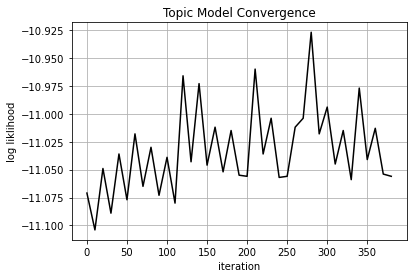

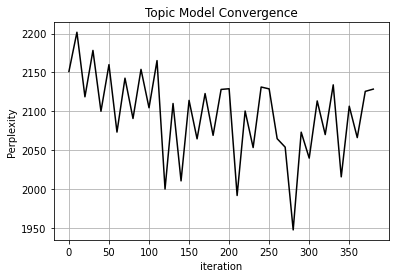

Note: Perplexity estimate based on a held-out corpus of 4 documents


In [27]:

p = re.compile(r"(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity")
matches = [p.findall(l) for l in open('gensim_nolem.log')]
matches = [m for m in matches if len(m) > 0]
tuples = [t[0] for t in matches]
perplexity = [float(t[1]) for t in tuples]
liklihood = [float(t[0]) for t in tuples]
iter = list(range(0,len(tuples)*10,10))
plt.plot(iter[:-1],liklihood[:-1],c="black")
plt.ylabel("log liklihood")
plt.xlabel("iteration")
plt.title("Topic Model Convergence")
plt.grid()
plt.show()


plt.plot(iter[:-1],perplexity[:-1],c="black")
plt.ylabel("Perplexity")
plt.xlabel("iteration")
plt.title("Topic Model Convergence")
plt.grid()
plt.show()
print('Note: Perplexity estimate based on a held-out corpus of 4 documents')


In [28]:
print('\nLog Likelihood(per-word ELBO): ', lda_model.log_perplexity(corpus))


Log Likelihood(per-word ELBO):  -11.35139410375823


In [29]:
coherence_model_lda = CoherenceModel(
   model=lda_model, texts=texts, dictionary=id2word, coherence='c_v'
)
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5497309076719765


## With Lemmatization and dictionary compression

In [30]:
starttime=time.time()
setUpNewLogFile('gensim_lem.log')

#Old code
#lda_model_lemmatized = gensim.models.ldamodel.LdaModel(

#New code uses multicore which runs works in parallel for each CPU core.
lda_model_lemmatized = gensim.models.ldamulticore.LdaMulticore(
   corpus=corpus_lemmatized, id2word=id2word_lemmatized, num_topics=20, random_state=100, 
   eval_every=1000, chunksize=1000, passes=10, alpha='symmetric', per_word_topics=True
)
print('Time taken = {:.0f} minutes'.format((time.time()-starttime)/60.0))

Time taken = 4 minutes


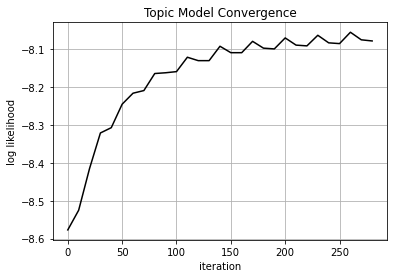

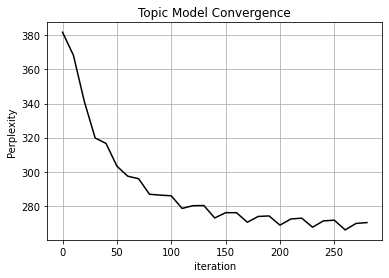

Note: Log likelihood is per-word ELBO
Note: Perplexity estimate based on a held-out corpus of 4 documents


In [31]:
p = re.compile(r"(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity")
matches = [p.findall(l) for l in open('gensim_lem.log')]
matches = [m for m in matches if len(m) > 0]
tuples = [t[0] for t in matches]
perplexity = [float(t[1]) for t in tuples]
liklihood = [float(t[0]) for t in tuples]
iter = list(range(0,len(tuples)*10,10))
plt.plot(iter[:-1],liklihood[:-1],c="black")
plt.ylabel("log likelihood")
plt.xlabel("iteration")
plt.title("Topic Model Convergence")
plt.grid()
plt.show()


plt.plot(iter[:-1],perplexity[:-1],c="black")
plt.ylabel("Perplexity")
plt.xlabel("iteration")
plt.title("Topic Model Convergence")
plt.grid()
plt.show()
print('Note: Log likelihood is per-word ELBO')
print('Note: Perplexity estimate based on a held-out corpus of 4 documents')


In [32]:
print('\nLog Likelihood(per-word ELBO): ', lda_model_lemmatized.log_perplexity(corpus_lemmatized))



Log Likelihood(per-word ELBO):  -8.056201668835016


In [33]:
coherence_model_lda_lemmatized = CoherenceModel(
   model=lda_model_lemmatized, texts=data_lemmatized_filtered, dictionary=id2word_lemmatized, coherence='c_v'
)
coherence_lda_lemmatized = coherence_model_lda_lemmatized.get_coherence()
print('\nCoherence Score: ', coherence_lda_lemmatized)




Coherence Score:  0.639390651206254


# About how gensim reports perplexity
https://tedboy.github.io/nlps/_modules/gensim/models/ldamodel.html#LdaModel.log_perplexity

    They calculate the ELBO of the variational inferred q vs p in function "bound"
    
        def bound(self, corpus, gamma=None, subsample_ratio=1.0):
            Estimate the variational bound of documents from `corpus`:
            E_q[log p(corpus)] - E_q[log q(corpus)]
        
    Then they divide the ELBO by the number of words/tokens so that it is "per-word".
    The likelihood reported above is the per-word likelihood, and perplexity=2^(-bound)
        
        def log_perplexity(self, chunk, total_docs=None):
            Calculate and return per-word likelihood bound, using the `chunk` of
            documents as evaluation corpus. Also output the calculated statistics. incl.
            perplexity=2^(-bound), to log at INFO level.


## Finding the right value of K

In [34]:
K_Coherence={}
models={}

In [35]:

for K in [5,10,15,20,25,30,40]:
    print('Starting K={}'.format(K))
    starttime=time.time()
    setUpNewLogFile('gensim_lem_{}.log'.format(K))

    #New code uses multicore which runs works in parallel for each CPU core.
    lda_model_lemmatized = gensim.models.ldamulticore.LdaMulticore(
       corpus=corpus_lemmatized, id2word=id2word_lemmatized, num_topics=K, random_state=100, 
       eval_every=1000, chunksize=1000, passes=8, alpha='symmetric', per_word_topics=True
    )
    coherence_model_lda_lemmatized = CoherenceModel(
       model=lda_model_lemmatized, texts=data_lemmatized_filtered, dictionary=id2word_lemmatized, coherence='c_v'
    )
    coherence_lda_lemmatized = coherence_model_lda_lemmatized.get_coherence()
    print('Coherence Score: ', coherence_lda_lemmatized)
    K_Coherence[K]=coherence_lda_lemmatized
    print('Time taken = {:.0f} minutes'.format((time.time()-starttime)/60.0))
    models[K]=lda_model_lemmatized

Starting K=5
Coherence Score:  0.538652983441009
Time taken = 4 minutes
Starting K=10
Coherence Score:  0.6099184296764066
Time taken = 4 minutes
Starting K=15
Coherence Score:  0.5973412754528363
Time taken = 5 minutes
Starting K=20
Coherence Score:  0.639642445838058
Time taken = 5 minutes
Starting K=25
Coherence Score:  0.6345741806955959
Time taken = 5 minutes
Starting K=30
Coherence Score:  0.6068648435452109
Time taken = 5 minutes
Starting K=40
Coherence Score:  0.5876884859335876
Time taken = 6 minutes


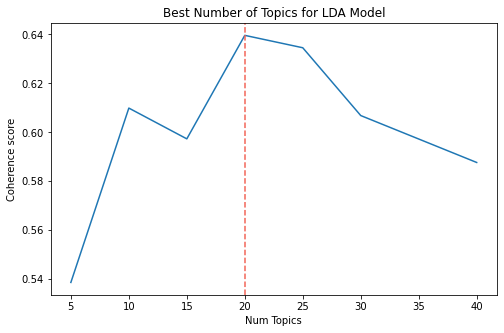

In [36]:
plt.figure(figsize=(8,5))

x = list(K_Coherence.keys())
coherence_values= list(K_Coherence.values())

# Build the line plot
#ax = sns.lineplot(x=x, y=coherence_values, color='#238C8C')
ax=plt.plot(x,coherence_values)

# Set titles and labels
plt.title("Best Number of Topics for LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")

# Add a vertical line to show the optimum number of topics
plt.axvline(x[np.argmax(coherence_values)], 
            color='#F26457', linestyle='--')


# Exploring final model (with Lemmatization)

In [37]:
#Choose model with K=20
lda_model_lemmatized=models[20]

In [38]:
pprint(lda_model_lemmatized.print_topics())

[(0,
  '0.007*"displaystyle" + 0.006*"example" + 0.005*"cell" + 0.005*"function" + '
  '0.005*"language" + 0.004*"case" + 0.004*"term" + 0.004*"protein" + '
  '0.004*"result" + 0.004*"type"'),
 (1,
  '0.060*"film" + 0.011*"star" + 0.009*"series" + 0.008*"direct" + '
  '0.007*"character" + 0.006*"movie" + 0.005*"award" + 0.005*"role" + '
  '0.005*"kill" + 0.005*"production"'),
 (2,
  '0.027*"club" + 0.024*"season" + 0.017*"league" + 0.016*"match" + '
  '0.015*"championship" + 0.014*"final" + 0.013*"football" + 0.012*"game" + '
  '0.011*"player" + 0.010*"event"'),
 (3,
  '0.010*"design" + 0.009*"system" + 0.007*"power" + 0.006*"engine" + '
  '0.006*"model" + 0.006*"car" + 0.005*"produce" + 0.005*"vehicle" + '
  '0.004*"low" + 0.004*"production"'),
 (4,
  '0.025*"station" + 0.024*"line" + 0.023*"road" + 0.016*"route" + '
  '0.014*"railway" + 0.012*"north" + 0.010*"highway" + 0.010*"bridge" + '
  '0.009*"train" + 0.009*"county"'),
 (5,
  '0.028*"woman" + 0.017*"medical" + 0.017*"hospital" 

In [39]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_lemmatized, corpus_lemmatized, id2word_lemmatized)
vis

C:\Users\jorda\anaconda3\envs\WH\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
9      0.006254  0.115608       1        1  9.492244
14     0.029273 -0.187056       2        1  6.775347
19     0.029087 -0.093741       3        1  5.980408
8     -0.071045  0.080589       4        1  5.918084
10     0.030992  0.074262       5        1  5.850291
0      0.173221 -0.070891       6        1  5.617872
18     0.040728  0.089063       7        1  5.516817
17     0.174767  0.032091       8        1  5.510315
2     -0.255895  0.070848       9        1  5.333070
7      0.052884  0.150494      10        1  5.278318
3      0.065578 -0.162891      11        1  5.276838
1     -0.046110  0.066358      12        1  4.851616
13     0.035114  0.064022      13        1  4.768809
12     0.082165  0.072348      14        1  4.623860
16    -0.078656 -0.081229      15        1  3.629793
15    -0.248962  0.048278      16        1  3.621561
11    -0.004816 -0.017158      17        1  3.504388
4     -0.062072 -0.203543      18        1  3.448551
6     -0.067249 -0.153993      19        1  2.757690
5      0.114743  0.106541      20        1  2.244127, topic_info=          Term          Freq         Total Category  logprob  loglift
993       film  21002.000000  21002.000000  Default  30.0000  30.0000
124     season  19073.000000  19073.000000  Default  29.0000  29.0000
621       game  18938.000000  18938.000000  Default  28.0000  28.0000
1512     album  11978.000000  11978.000000  Default  27.0000  27.0000
535       song  11640.000000  11640.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
798     center    505.971427   5955.728458  Topic20  -5.6822   1.3312
1884    mother    433.180033   4253.548490  Topic20  -5.8375   1.5125
1582  training    421.114228   3369.530631  Topic20  -5.8658   1.7172
1433      help    447.714745   6888.490829  Topic20  -5.8045   1.0634
10       cause    440.150275   5864.113205  Topic20  -5.8215   1.2074

[1745 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
16119     17  0.980060  abc_affiliate
10866      5  0.975239       abdicate
19985      5  0.949205     abdication
4516       1  0.052752       abortion
4516       4  0.002512       abortion
...      ...       ...            ...
9900      13  0.970746        zionist
11817      1  0.030702         zombie
11817      4  0.061404         zombie
11817     12  0.880131         zombie
11817     17  0.020468         zombie

[13028 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 15, 20, 9, 11, 1, 19, 18, 3, 8, 4, 2, 14, 13, 17, 16, 12, 5, 7, 6])

# Exploring underlying code

This code is obtained from the below by the GNU General Public License, and adapted and modified for use here.
Please see https://github.com/blei-lab/onlineldavb/blob/master/onlineldavb.py



In [115]:


# onlineldavb.py: Package of functions for fitting Latent Dirichlet
# Allocation (LDA) with online variational Bayes (VB).
#
# Copyright (C) 2010  Matthew D. Hoffman
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.

import sys, re, time, string
import numpy as n
from scipy.special import gammaln, psi


n.random.seed(100000001)
meanchangethresh = 0.001


![LDA ALGO](https://github.com/duha-aldebakel/DSC180B-LDACode/blob/master/images/dirichlet_expectation.PNG?raw=true)



In [116]:
def dirichlet_expectation(alpha):
    """
    For a vector theta ~ Dir(alpha), computes E[log(theta)] given alpha.
    """
    if (len(alpha.shape) == 1):
        return(psi(alpha) - psi(n.sum(alpha)))
    return(psi(alpha) - psi(n.sum(alpha, 1))[:, n.newaxis])

In [120]:
dirichlet_expectation(np.array([-1,0,0.5,1.0,100]))

array([            nan,            -inf, -6.56868438e+00, -5.18239002e+00,
       -5.01249984e-03])

In [121]:

class OnlineLDA:
    """
    Implements online VB for LDA as described in (Hoffman et al. 2010).
    """

    def __init__(self, vocab, K, D, alpha, eta, tau0, kappa):
        """
        Arguments:
        K: Number of topics
        vocab: A set of words to recognize. When analyzing documents, any word
           not in this set will be ignored.
        D: Total number of documents in the population. For a fixed corpus,
           this is the size of the corpus. In the truly online setting, this
           can be an estimate of the maximum number of documents that
           could ever be seen.
        alpha: Hyperparameter for prior on weight vectors theta
        eta: Hyperparameter for prior on topics beta
        tau0: A (positive) learning parameter that downweights early iterations
        kappa: Learning rate: exponential decay rate---should be between
             (0.5, 1.0] to guarantee asymptotic convergence.
        Note that if you pass the same set of D documents in every time and
        set kappa=0 this class can also be used to do batch VB.
        """
        self._vocab = dict()
        for word in vocab:
            #This will be done in preprocessing.
            #word = word.lower()
            #word = re.sub(r'[^a-z]', '', word)
            self._vocab[word] = len(self._vocab)

        self._K = K
        self._W = len(self._vocab)
        self._D = D
        self._alpha = alpha
        self._eta = eta
        self._tau0 = tau0 + 1
        self._kappa = kappa
        self._updatect = 0

        # Initialize the variational distribution q(beta|lambda)
        self._lambda = 1*n.random.gamma(100., 1./100., (self._K, self._W))
        self._Elogbeta = dirichlet_expectation(self._lambda)
        self._expElogbeta = n.exp(self._Elogbeta)

    def do_e_step(self, wordids, wordcts):
        """
        Given a mini-batch of documents, estimates the parameters
        gamma controlling the variational distribution over the topic
        weights for each document in the mini-batch.
        Arguments:
        docs:  List of D documents. Each document must be represented
               as a string. (Word order is unimportant.) Any
               words not in the vocabulary will be ignored.
        Returns a tuple containing the estimated values of gamma,
        as well as sufficient statistics needed to update lambda.
        """

        batchD = len(wordids)

        # Initialize the variational distribution q(theta|gamma) for
        # the mini-batch
        gamma = 1*n.random.gamma(100., 1./100., (batchD, self._K))
        Elogtheta = dirichlet_expectation(gamma)
        expElogtheta = n.exp(Elogtheta)

        sstats = n.zeros(self._lambda.shape)
        # Now, for each document d update that document's gamma and phi
        it = 0
        meanchange = 0
        for d in range(0, batchD):
            # print(sum(wordcts[d]))
            # These are mostly just shorthand (but might help cache locality)
            ids = wordids[d]
            cts = wordcts[d]
            gammad = gamma[d, :]
            Elogthetad = Elogtheta[d, :]
            expElogthetad = expElogtheta[d, :]
            expElogbetad = self._expElogbeta[:, ids]                              
            # The optimal phi_{dwk} is proportional to 
            # expElogthetad_k * expElogbetad_w. phinorm is the normalizer.
            phinorm = n.dot(expElogthetad, expElogbetad) + 1e-100
            # Iterate between gamma and phi until convergence
            for it in range(0, 100):
                lastgamma = gammad
                # We represent phi implicitly to save memory and time.
                # Substituting the value of the optimal phi back into
                # the update for gamma gives this update. Cf. Lee&Seung 2001.
                gammad = self._alpha + expElogthetad * \
                    n.dot(cts / phinorm, expElogbetad.T)                          #<----E step gamma update
                #print(gammad[:, n.newaxis])
                Elogthetad = dirichlet_expectation(gammad)                        # we use gammad to calculate Elogthetad
                expElogthetad = n.exp(Elogthetad)
                phinorm = n.dot(expElogthetad, expElogbetad) + 1e-100             #<----E step phi update
                # If gamma hasn't changed much, we're done.
                meanchange = n.mean(abs(gammad - lastgamma))
                if (meanchange < meanchangethresh):                               #<----E step ends when gamma stop changing
                    break
            gamma[d, :] = gammad
            # Contribution of document d to the expected sufficient
            # statistics for the M step.
            sstats[:, ids] += n.outer(expElogthetad.T, cts/phinorm)               #lambda shape is (k,w)

        # This step finishes computing the sufficient statistics for the
        # M step, so that
        # sstats[k, w] = \sum_d n_{dw} * phi_{dwk} 
        # = \sum_d n_{dw} * exp{Elogtheta_{dk} + Elogbeta_{kw}} / phinorm_{dw}.
        sstats = sstats * self._expElogbeta

        return((gamma, sstats))


    def update_lambda(self, wordids, wordcts):
        """
        First does an E step on the mini-batch given in wordids and
        wordcts, then uses the result of that E step to update the
        variational parameter matrix lambda.
        Arguments:
        docs:  List of D documents. Each document must be represented
               as a string. (Word order is unimportant.) Any
               words not in the vocabulary will be ignored.
        Returns gamma, the parameters to the variational distribution
        over the topic weights theta for the documents analyzed in this
        update.
        Also returns an estimate of the variational bound for the
        entire corpus for the OLD setting of lambda based on the
        documents passed in. This can be used as a (possibly very
        noisy) estimate of held-out likelihood.
        """

        # rhot will be between 0 and 1, and says how much to weight
        # the information we got from this mini-batch.
        rhot = pow(self._tau0 + self._updatect, -self._kappa)
        self._rhot = rhot
        # Do an E step to update gamma, phi | lambda for this
        # mini-batch. This also returns the information about phi that
        # we need to update lambda.
        (gamma, sstats) = self.do_e_step(wordids, wordcts)
        # Estimate held-out likelihood for current values of lambda.
        bound = self.approx_bound(wordids, wordcts, gamma)
        # Update lambda based on documents.
        self._lambda = self._lambda * (1-rhot) + \
            rhot * (self._eta + self._D * sstats / len(wordids))               #<----M step. eta="n",
                                                                               #     sstats captures summand from estep but across documents
        self._Elogbeta = dirichlet_expectation(self._lambda)                   # we use lambda to calculate expElogbeta
        self._expElogbeta = n.exp(self._Elogbeta)
        self._updatect += 1

        return(gamma, bound)

    def approx_bound(self, wordids, wordcts, gamma):
        """
        Estimates the variational bound over *all documents* using only
        the documents passed in as "docs." gamma is the set of parameters
        to the variational distribution q(theta) corresponding to the
        set of documents passed in.
        The output of this function is going to be noisy, but can be
        useful for assessing convergence.
        """

        # This is to handle the case where someone just hands us a single
        # document, not in a list.
        batchD = len(wordids)

        score = 0
        Elogtheta = dirichlet_expectation(gamma)
        expElogtheta = n.exp(Elogtheta)

        # E[log p(docs | theta, beta)]
        for d in range(0, batchD):
            ids = wordids[d]
            cts = n.array(wordcts[d])
            phinorm = n.zeros(len(ids))
            for i in range(0, len(ids)):
                temp = Elogtheta[d, :] + self._Elogbeta[:, ids[i]]
                tmax = max(temp)
                phinorm[i] = n.log(sum(n.exp(temp - tmax))) + tmax
            score += n.sum(cts * phinorm)
#             oldphinorm = phinorm
#             phinorm = n.dot(expElogtheta[d, :], self._expElogbeta[:, ids])
#             score += n.sum(cts * n.log(phinorm))

        # E[log p(theta | alpha) - log q(theta | gamma)]
        score += n.sum((self._alpha - gamma)*Elogtheta)
        score += n.sum(gammaln(gamma) - gammaln(self._alpha))
        score += sum(gammaln(self._alpha*self._K) - gammaln(n.sum(gamma, 1)))

        # Compensate for the subsampling of the population of documents
        score = score * self._D / len(wordids)

        # E[log p(beta | eta) - log q (beta | lambda)]
        score = score + n.sum((self._eta-self._lambda)*self._Elogbeta)
        score = score + n.sum(gammaln(self._lambda) - gammaln(self._eta))
        score = score + n.sum(gammaln(self._eta*self._W) - 
                              gammaln(n.sum(self._lambda, 1)))

        return(score)





![LDA ALGO](https://github.com/duha-aldebakel/DSC180B-LDACode/blob/master/images/VB_LDA.PNG?raw=true)

![LDA ALGO](https://github.com/duha-aldebakel/DSC180B-LDACode/blob/master/images/VB_LDA_Algo1.PNG?raw=true)


What is the variational family q?

Blei and Hoffman uses a mean field variational inference to approximate p.

The variational family q assumes that β, θ, z are independent and can be fully factored.

$$q(β, θ, z) = \prod_{k} q(β_k) \prod_{d} q(θ_d) \prod_{n} q(z_{dn})$$

where 
(topic assignments)
$$q(z_{di} = k) = φ_{dwdik}     i.e. categorical$$        
(topic proportions)
$$q(θ_d) = Dirichlet(θ_d; γ_d) $$                         
(topics)
$$q(β_k) = Dirichlet(β_k; λ_k)$$                          

Note that the posterior p also has
$$ θ_d \sim Dirichlet(\alpha)$$
$$ z_{di} \sim Multinomial(θ)$$
and so the distributions are mirrored in q, but the big difference is the dependence of the terms (such as between θ and β) in p which make the calculation intractable.

In [108]:
if True:
    
    K = 20 #number of topics
    D = 100000 #estimate of number of documents in the population
    S = 1000 #sample size of a batch
    alpha = 0.1
    eta = 0.01
    tau0 = 1
    kappa = 0.75    
    '''
        Hyperparameter of Dirichlet priors
            concentration parameter of Dirichlet prior, which smaller meaning more concentrated
            we like it to be relatively concentrated since any topic usually uses a small number of key words
            we allow one document to have more than one topic, but we want to penalize it when there are too many potential topics
            
        alpha: Hyperparameter for prior on weight vectors theta
        eta: Hyperparameter for prior on topics beta
        
        Learning rate parameters:
        tau0: A (positive) learning parameter that downweights early iterations
        kappa: Learning rate: exponential decay rate---should be between
             (0.5, 1.0] to guarantee asymptotic convergence.
             

        For each document d, we would like to know the distributions of 
            theta, the topic distribution of the document
            z_n, the topic of n-th word in document
            (so for each document, there is one theta and N z_n)
            
        but we only observe
            w_n, the actual n-th word in document
            
            
    '''
    
    vocab=list(id2word_lemmatized.token2id.keys())
    model = OnlineLDA(vocab, K, D, alpha, eta, tau0, kappa)
   
    bounds=[]
    bounds_h=[]
    for i in range(100):
        j=i%50 #We only have 50k documents, so we make another pass after 50
        batch=corpus_lemmatized[(j*S):((j+1)*S)]
        wordids = [[w for w,c in doc] for doc in batch]
        wordcts = [[c for w,c in doc] for doc in batch]
        if i==0:
            holdids=wordids #First batch is the holdout
            holdcts=wordcts #First batch is the holdout
        if j==0:
            continue #Don't use holdout for learning
            
        (gamma, bound)=model.update_lambda(wordids, wordcts)
        (gamma_h, sstats_h) = model.do_e_step(holdids, holdcts)
        # Estimate held-out likelihood for current values of lambda.
        bound_h = model.approx_bound(holdids, holdcts, gamma_h)
        
        #bound is the evidence lower bound (ELBO)
        print('batch {} bound {} bound_h {}'.format(i,bound,bound_h))
        bounds.append(bound)
        bounds_h.append(bound_h)
    

batch 1 bound -155339867.85067126 bound_h -115263275.04043162
batch 2 bound -117334871.95158228 bound_h -113177070.00154924
batch 3 bound -117179902.6672188 bound_h -112010544.05325556
batch 4 bound -117133765.00037892 bound_h -111008272.6372714
batch 5 bound -107414109.28890584 bound_h -110230580.39880744
batch 6 bound -111612641.24798283 bound_h -109655124.11801273
batch 7 bound -105161036.67340252 bound_h -109236544.0688131
batch 8 bound -104782042.8409715 bound_h -108685054.90389451
batch 9 bound -123153652.47885731 bound_h -108176591.9045179
batch 10 bound -104152565.41339846 bound_h -107881460.74707814
batch 11 bound -114747005.11846226 bound_h -107490249.69983394
batch 12 bound -107788286.61708285 bound_h -107220441.5048766
batch 13 bound -102201463.93308075 bound_h -107017633.54462841
batch 14 bound -113344624.31043525 bound_h -106747598.92157723
batch 15 bound -101895052.94606687 bound_h -106597459.45707056
batch 16 bound -130153985.10231233 bound_h -106456127.92524382
batch 1

Text(0.5, 1.0, 'ELBO on holdout set of 1k documents')

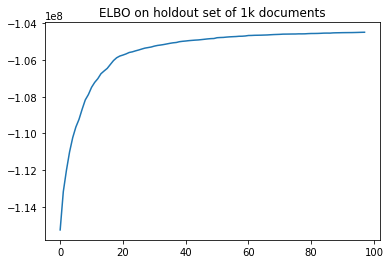

In [111]:
plt.plot(range(len(bounds_h)),bounds_h)
plt.title('ELBO on holdout set of 1k documents')

Text(0.5, 1.0, 'Per-word likelihood on holdout set of 1k documents')

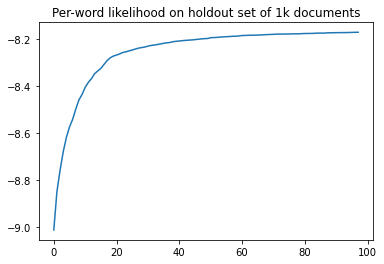

In [132]:
perword_bounds_h=[0.01*y/sum([sum(x) for x in holdcts]) for y in bounds_h]
plt.plot(range(len(perword_bounds_h)),perword_bounds_h)
plt.title('Per-word likelihood on holdout set of 1k documents')

Text(0.5, 1.0, 'Per-word likelihood on holdout set of 1k documents')

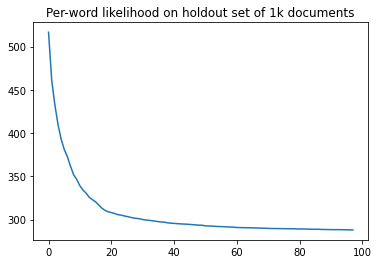

In [133]:
perplexity=[2**(-y) for y in perword_bounds_h]
plt.plot(range(len(perplexity)),perplexity)
plt.title('Per-word likelihood on holdout set of 1k documents')